# Importar dataset

In [49]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("uom190346a/e-commerce-customer-behavior-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'e-commerce-customer-behavior-dataset' dataset.
Path to dataset files: /kaggle/input/e-commerce-customer-behavior-dataset


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


## Carga y análisis exploratorio

In [51]:
import os
csv_file_path = os.path.join(path, 'E-commerce Customer Behavior - Sheet1.csv')

df = pd.read_csv(csv_file_path)

# Dimensiones del dataset
print("Shape:", df.shape)
# Primeras filas
df.head()

# Información general y nulos
df.info()
print("\nValores nulos por columna:")
print(df.isna().sum())

# 3. Estadística descriptiva
df.describe(include="all").transpose()




Shape: (350, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               350 non-null    int64  
 1   Gender                    350 non-null    object 
 2   Age                       350 non-null    int64  
 3   City                      350 non-null    object 
 4   Membership Type           350 non-null    object 
 5   Total Spend               350 non-null    float64
 6   Items Purchased           350 non-null    int64  
 7   Average Rating            350 non-null    float64
 8   Discount Applied          350 non-null    bool   
 9   Days Since Last Purchase  350 non-null    int64  
 10  Satisfaction Level        348 non-null    object 
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 27.8+ KB

Valores nulos por columna:
Customer ID                 0
Gender                      0
Age

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Customer ID,350.0,NaN,NaN,NaN,275.5,101.180532,101.0,188.25,275.5,362.75,450.0
Gender,350,2,Female,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,350.0,NaN,NaN,NaN,33.597143,4.870882,26.0,30.0,32.5,37.0,43.0
City,350,6,New York,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Membership Type,350,3,Gold,117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Spend,350.0,NaN,NaN,NaN,845.381714,362.058695,410.8,502.0,775.2,1160.6,1520.1
Items Purchased,350.0,NaN,NaN,NaN,12.6,4.155984,7.0,9.0,12.0,15.0,21.0
Average Rating,350.0,NaN,NaN,NaN,4.019143,0.580539,3.0,3.5,4.1,4.5,4.9
Discount Applied,350,2,True,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Days Since Last Purchase,350.0,NaN,NaN,NaN,26.588571,13.440813,9.0,15.0,23.0,38.0,63.0


In [52]:
num_cols = ["Age", "Total Spend", "Items Purchased",
            "Average Rating", "Days Since Last Purchase"]

cat_cols = ["Gender", "City", "Membership Type",
            "Discount Applied", "Satisfaction Level"]

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)




Numéricas: ['Age', 'Total Spend', 'Items Purchased', 'Average Rating', 'Days Since Last Purchase']
Categóricas: ['Gender', 'City', 'Membership Type', 'Discount Applied', 'Satisfaction Level']


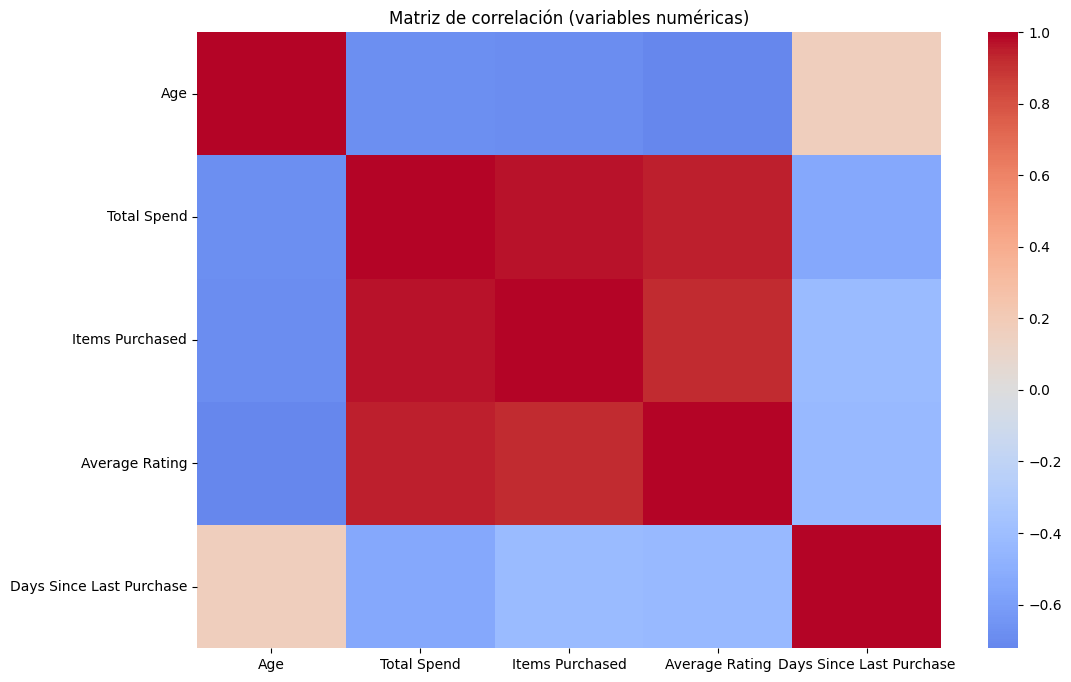

In [53]:
plt.figure(figsize=(12, 8))
corr = df[num_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matriz de correlación (variables numéricas)")
plt.show()


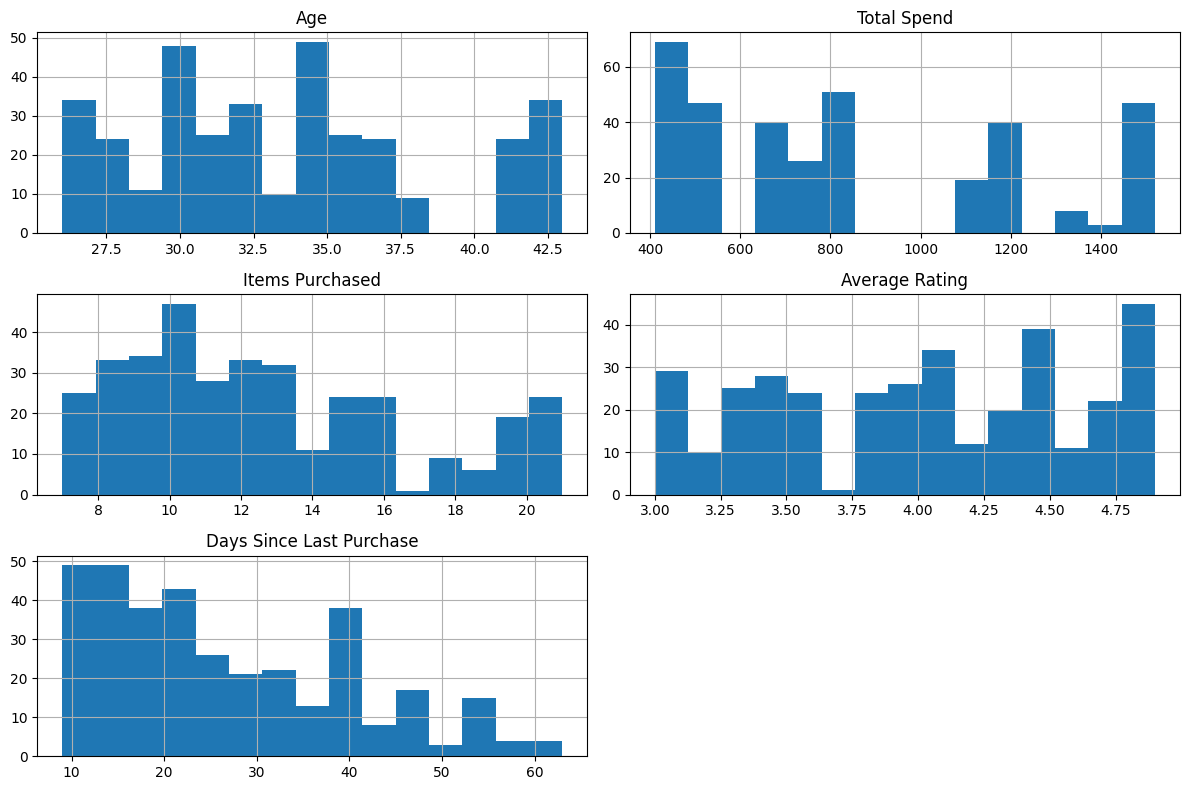

In [54]:
df[num_cols].hist(bins=15, figsize=(12, 8))
plt.tight_layout()
plt.show()

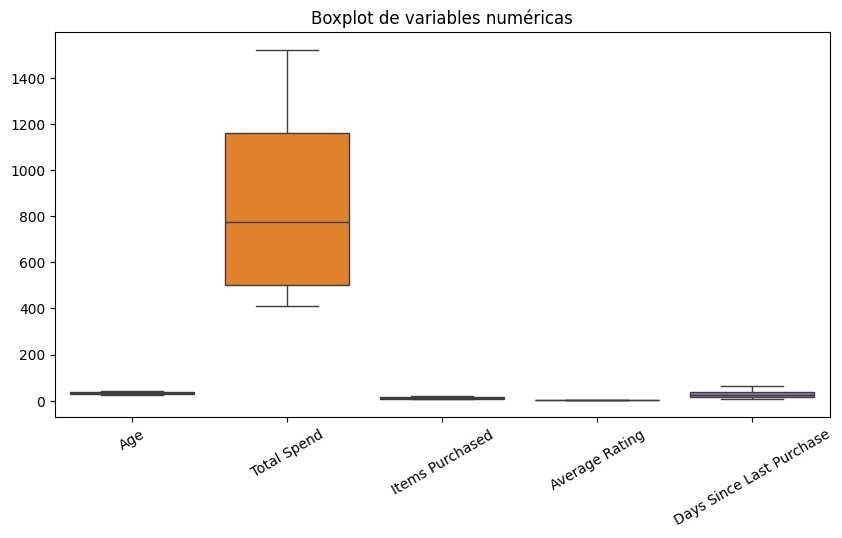

In [55]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[num_cols])
plt.xticks(rotation=30)
plt.title("Boxplot de variables numéricas")
plt.show()

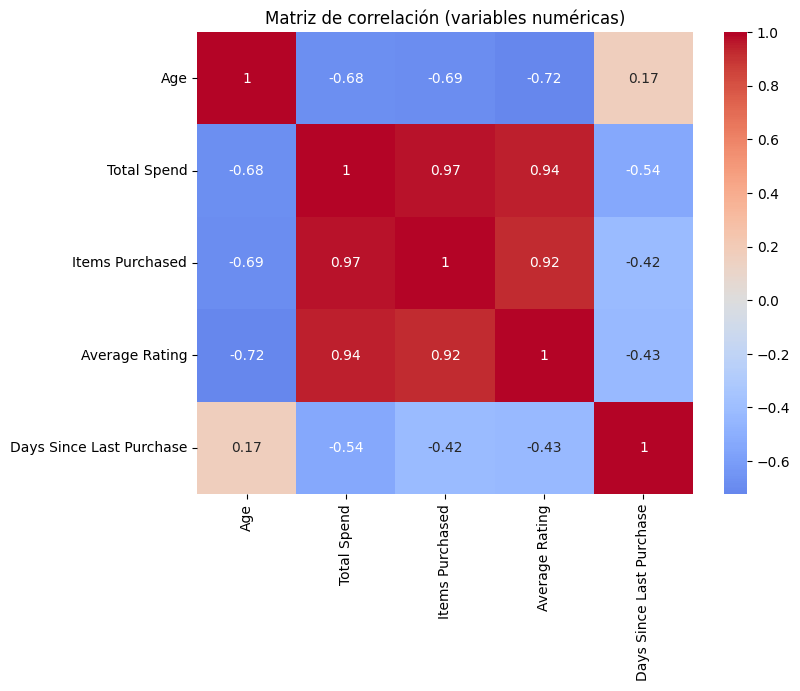

In [56]:
plt.figure(figsize=(8, 6))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de correlación (variables numéricas)")
plt.show()

# Preprocesamiento

In [57]:
# Creamos una copia del DataFrame original para trabajar sobre ella
df_model = df.copy()

# 1) Eliminamos 'Customer ID' porque es solo un identificador único
#    y no aporta información de comportamiento ni de perfil.
df_model = df_model.drop(columns=["Customer ID"])

# 2) Guardamos 'Satisfaction Level' en una variable aparte.
#    Esta columna NO la vamos a usar como entrada de los modelos no supervisados,
#    pero sí nos servirá después para interpretar los clusters
#    (por ejemplo: qué grupo tiene más clientes 'Satisfied').
satisfaction = df_model["Satisfaction Level"]

# 3) Eliminamos 'Satisfaction Level' de df_model para que no entre en el clustering.
df_model = df_model.drop(columns=["Satisfaction Level"])

# Revisamos cómo quedó el DataFrame para el modelo
df_model.head()


,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase
0,Female,29,New York,Gold,1120.20,14,4.6,True,25
1,Male,34,Los Angeles,Silver,780.50,11,4.1,False,18
2,Female,43,Chicago,Bronze,510.75,9,3.4,True,42
3,Male,30,San Francisco,Gold,1480.30,19,4.7,False,12
4,Male,27,Miami,Silver,720.40,13,4.0,True,55


In [58]:
# Aplicamos One-Hot Encoding (variables dummy) a las columnas categóricas.
# - columns: lista de columnas categóricas a transformar.
# - drop_first=True: elimina la primera categoría de cada variable
#   para evitar redundancia (trampa de la multicolinealidad).
df_encoded = pd.get_dummies(
    df_model,
    columns=["Gender", "City", "Membership Type", "Discount Applied"],
    drop_first=True
)

# Visualizamos las primeras filas ya codificadas.
# Ahora todas las columnas deberían ser numéricas (int o float).
df_encoded.head()


,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase,Gender_Male,City_Houston,City_Los Angeles,City_Miami,City_New York,City_San Francisco,Membership Type_Gold,Membership Type_Silver,Discount Applied_True
0,29,1120.20,14,4.6,25,False,False,False,False,True,False,True,False,True
1,34,780.50,11,4.1,18,True,False,True,False,False,False,False,True,False
2,43,510.75,9,3.4,42,False,False,False,False,False,False,False,False,True
3,30,1480.30,19,4.7,12,True,False,False,False,False,True,True,False,False
4,27,720.40,13,4.0,55,True,False,False,True,False,False,False,True,True


In [59]:
# Definimos la matriz de características X a partir del DataFrame codificado.
# X contiene todas las variables numéricas que servirán como entrada
# para los algoritmos de aprendizaje no supervisado.
X = df_encoded.values

# Verificamos la forma de la matriz: (número de muestras, número de características)
X.shape

# Creamos el objeto escalador
scaler = StandardScaler()

# Ajustamos el escalador a los datos y transformamos X.
# El resultado es X_scaled, donde cada columna tiene media ~0 y desviación estándar ~1.
X_scaled = scaler.fit_transform(X)

# Verificamos la forma de la matriz escalada (debe ser igual que X)
X_scaled.shape

(350, 14)

# Implementación de Clustering

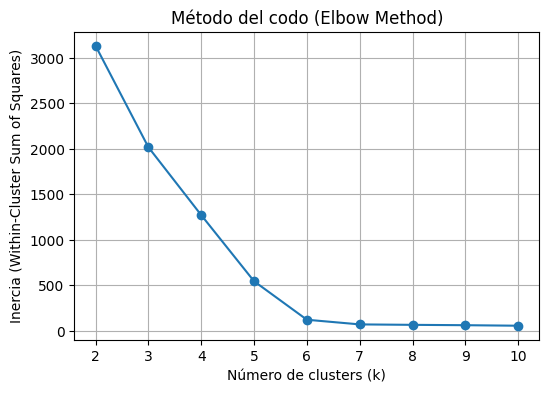

k = 2, silhouette score = 0.417
k = 3, silhouette score = 0.522
k = 4, silhouette score = 0.644
k = 5, silhouette score = 0.765
k = 6, silhouette score = 0.861
k = 7, silhouette score = 0.861
k = 8, silhouette score = 0.801
k = 9, silhouette score = 0.735
k = 10, silhouette score = 0.662


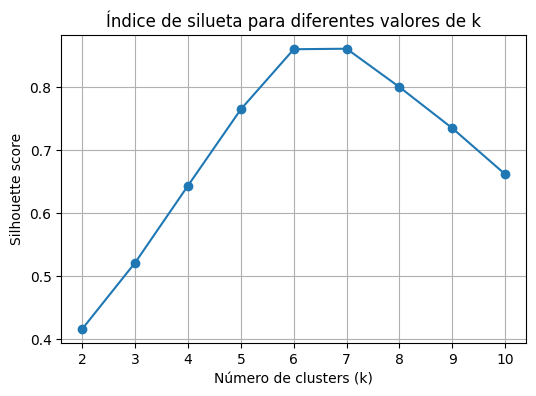

In [60]:
# ============================
# 4.1. K-means: Método del codo
# ============================


# Lista para guardar la inercia (WCSS) para cada valor de k
wcss = []

# Rango de k a evaluar (puedes ajustar el rango si lo necesitas)
K = range(2, 11)

for k in K:
    # Creamos el modelo KMeans con k clusters
    # random_state se fija para obtener resultados reproducibles
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")

    # Entrenamos el modelo sobre los datos escalados
    kmeans.fit(X_scaled)

    # Guardamos la inercia (suma de distancias cuadráticas dentro de cada cluster)
    wcss.append(kmeans.inertia_)

# Graficamos el "codo": k vs inercia
plt.figure(figsize=(6, 4))
plt.plot(K, wcss, marker="o")
plt.title("Método del codo (Elbow Method)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (Within-Cluster Sum of Squares)")
plt.xticks(K)
plt.grid(True)
plt.show()


silhouette_scores = []

for k in K:
    # Ajustamos K-means para cada valor de k
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_scaled)

    # Calculamos el índice de silueta:
    # Mide qué tan separados y compactos están los clusters (entre -1 y 1).
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

    print(f"k = {k}, silhouette score = {score:.3f}")

# Graficamos el silhouette score en función de k
plt.figure(figsize=(6, 4))
plt.plot(K, silhouette_scores, marker="o")
plt.title("Índice de silueta para diferentes valores de k")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette score")
plt.xticks(K)
plt.grid(True)
plt.show()


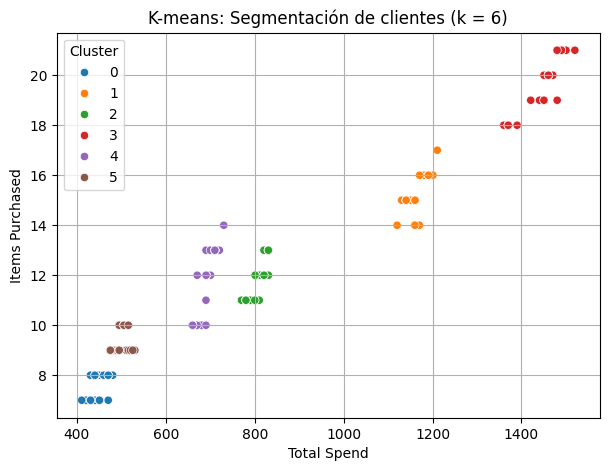

In [61]:
# ==============================================
# 4.3. Entrenamiento del modelo final con K-means
# ==============================================

# IMPORTANTE: ajusta este valor según tu análisis de elbow + silhouette
k_optimo = 6  # <-- cambia este valor si tus gráficos indican otro k

# Creamos y entrenamos el modelo K-means final
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init="auto")
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Añadimos las etiquetas de cluster al conjunto codificado
df_clusters = df_encoded.copy()
df_clusters["Cluster"] = cluster_labels

# (Opcional) Si quieres también anexar el nivel de satisfacción para análisis posterior:
df_clusters["Satisfaction Level"] = satisfaction.values

# Vista rápida de los primeros registros con su cluster asignado
df_clusters.head()

# ==================================================
# 4.4. Visualización 2D de K-means (espacio original)
# ==================================================

# Usamos el DataFrame original df (no escalado) para que los ejes tengan unidades interpretables
df_plot = df.copy()

# Añadimos las etiquetas de cluster al DataFrame original
df_plot["Cluster"] = cluster_labels

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_plot,
    x="Total Spend",
    y="Items Purchased",
    hue="Cluster",
    palette="tab10"
)
plt.title(f"K-means: Segmentación de clientes (k = {k_optimo})")
plt.xlabel("Total Spend")
plt.ylabel("Items Purchased")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


Se compararon diferentes valores de k mediante el método del codo y el índice de silueta.
Los mejores resultados se obtuvieron con k = 6 (silhouette ≈ 0.86).
Aunque k = 4 genera segmentos más simples desde el punto de vista de negocio, su calidad de separación es claramente inferior, por lo que se seleccionó k = 6 como configuración final del modelo K-means.

In [62]:
# =================================
# 5.1. Búsqueda de parámetros DBSCAN
# =================================

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Lista de valores de eps que queremos probar
eps_values = [0.4, 0.6, 0.8, 1.0, 1.2]
min_samples_values = [5, 10]

resultados_dbscan = []

for eps in eps_values:
    for min_s in min_samples_values:
        # Definimos el modelo DBSCAN con los parámetros a evaluar
        dbscan = DBSCAN(eps=eps, min_samples=min_s)

        # Ajuste del modelo y obtención de etiquetas
        labels = dbscan.fit_predict(X_scaled)

        # Número de clusters encontrados (excluyendo ruido = etiqueta -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Si solo hay 0 o 1 cluster "real", no tiene sentido calcular silueta
        if n_clusters <= 1:
            silhouette = np.nan
        else:
            silhouette = silhouette_score(X_scaled, labels)

        resultados_dbscan.append({
            "eps": eps,
            "min_samples": min_s,
            "n_clusters": n_clusters,
            "silhouette": silhouette
        })

# Mostramos los resultados ordenados por silhouette
resultados_dbscan_sorted = sorted(
    resultados_dbscan,
    key=lambda x: (np.nan_to_num(x["silhouette"]), x["n_clusters"]),
    reverse=True
)

for r in resultados_dbscan_sorted:
    print(f"eps={r['eps']}, min_samples={r['min_samples']}, "
          f"clusters={r['n_clusters']}, silhouette={r['silhouette']:.3f}")


eps=0.6, min_samples=5, clusters=7, silhouette=0.849
eps=0.6, min_samples=10, clusters=7, silhouette=0.849
eps=0.8, min_samples=5, clusters=7, silhouette=0.849
eps=0.8, min_samples=10, clusters=7, silhouette=0.849
eps=1.0, min_samples=5, clusters=7, silhouette=0.849
eps=1.0, min_samples=10, clusters=7, silhouette=0.849
eps=1.2, min_samples=5, clusters=7, silhouette=0.849
eps=1.2, min_samples=10, clusters=7, silhouette=0.849
eps=0.4, min_samples=10, clusters=9, silhouette=0.622
eps=0.4, min_samples=5, clusters=13, silhouette=0.595


Número de clusters DBSCAN (sin contar ruido): 7


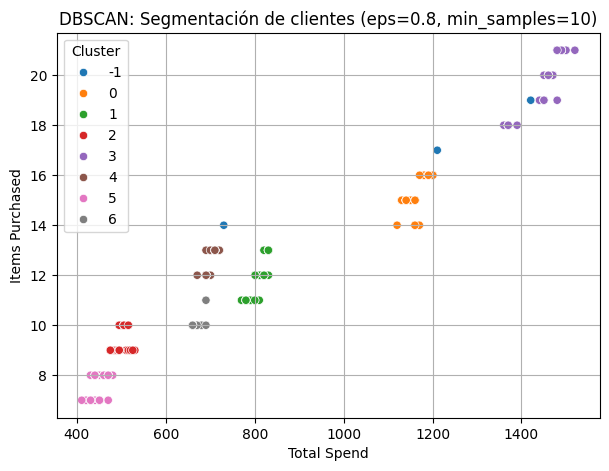

In [63]:
# ====================================
# 5.2. Modelo final DBSCAN y visualización
# ====================================

# Sustituye estos valores por los que elijas de la búsqueda anterior
eps_optimo = 0.8
min_samples_optimo = 10

dbscan_final = DBSCAN(eps=eps_optimo, min_samples=min_samples_optimo)
dbscan_labels = dbscan_final.fit_predict(X_scaled)

# Añadimos las etiquetas de DBSCAN al DataFrame original
df_plot_dbscan = df.copy()
df_plot_dbscan["DBSCAN_Cluster"] = dbscan_labels

# Número de clusters encontrados (excluyendo ruido)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print("Número de clusters DBSCAN (sin contar ruido):", n_clusters_dbscan)

# Gráfico comparable al de K-means: Total Spend vs Items Purchased
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_plot_dbscan,
    x="Total Spend",
    y="Items Purchased",
    hue="DBSCAN_Cluster",
    palette="tab10"
)
plt.title(f"DBSCAN: Segmentación de clientes (eps={eps_optimo}, min_samples={min_samples_optimo})")
plt.xlabel("Total Spend")
plt.ylabel("Items Purchased")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


Varianza explicada por cada componente: [0.40608398 0.22299484]
Varianza total explicada (2 componentes): 0.6290788289883938


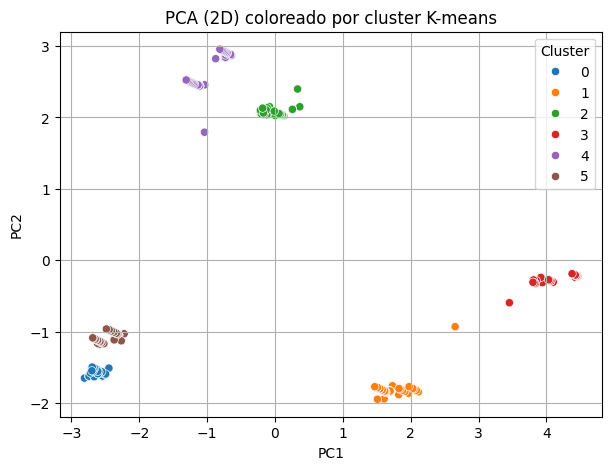

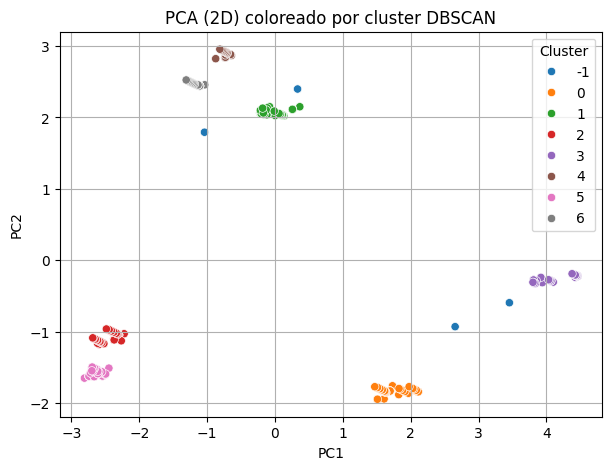

,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase,Gender_Male,City_Houston,City_Los Angeles,City_Miami,City_New York,City_San Francisco,Membership Type_Gold,Membership Type_Silver,Discount Applied_True
KMeans_Cluster,,,,,,,,,,,,,,
0,36.71,446.89,7.57,3.19,22.76,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30.71,1165.04,15.27,4.54,24.59,0.02,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,34.12,805.49,11.68,4.17,15.27,1.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,29.12,1459.77,20.00,4.81,11.17,1.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,28.95,690.39,11.64,3.93,45.50,0.98,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
5,42.02,499.88,9.41,3.46,40.47,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [64]:
# ===========================
# 6.1. PCA para visualización
# ===========================

from sklearn.decomposition import PCA

# Ajustamos PCA a los datos escalados y reducimos a 2 componentes
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Varianza explicada por cada componente:",
      pca.explained_variance_ratio_)
print("Varianza total explicada (2 componentes):",
      pca.explained_variance_ratio_.sum())

# Creamos un DataFrame con las componentes principales
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["KMeans_Cluster"] = cluster_labels
df_pca["DBSCAN_Cluster"] = dbscan_labels

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_pca,
    x="PC1",
    y="PC2",
    hue="KMeans_Cluster",
    palette="tab10"
)
plt.title("PCA (2D) coloreado por cluster K-means")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_pca,
    x="PC1",
    y="PC2",
    hue="DBSCAN_Cluster",
    palette="tab10"
)
plt.title("PCA (2D) coloreado por cluster DBSCAN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()



# Parte 6.1.1: Interpretación de Reducción de dimensionalidad con PCA
# DataFrame con SOLO las variables del modelo de K-means + etiqueta de cluster
df_km_vars = df_encoded.copy()
df_km_vars["KMeans_Cluster"] = cluster_labels

# Medias de TODAS las variables que se usaron en el modelo de K-means
df_km_vars.groupby("KMeans_Cluster").mean().round(2)




In [65]:
# Parte 6.1.2: Interpretación detallada de Reducción de dimensionalidad con PCA
# Mostrar algunos clientes por cluster
for i in sorted(df_km_vars["KMeans_Cluster"].unique()):
    print(f"\nCluster {i}")
    display(
        df_km_vars[df_km_vars["KMeans_Cluster"] == i].head()
    )


Cluster 0


,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase,Gender_Male,City_Houston,City_Los Angeles,City_Miami,City_New York,City_San Francisco,Membership Type_Gold,Membership Type_Silver,Discount Applied_True,KMeans_Cluster
5,37,440.8,8,3.1,22,False,True,False,False,False,False,False,False,False,0
11,36,470.5,7,3.2,20,False,True,False,False,False,False,False,False,False,0
17,38,450.9,8,3.0,25,False,True,False,False,False,False,False,False,False,0
23,37,430.8,7,3.4,23,False,True,False,False,False,False,False,False,False,0
29,36,460.5,8,3.1,19,False,True,False,False,False,False,False,False,False,0



Cluster 1


,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase,Gender_Male,City_Houston,City_Los Angeles,City_Miami,City_New York,City_San Francisco,Membership Type_Gold,Membership Type_Silver,Discount Applied_True,KMeans_Cluster
0,29,1120.2,14,4.6,25,False,False,False,False,True,False,True,False,True,1
6,31,1150.6,15,4.5,28,False,False,False,False,True,False,True,False,True,1
12,30,1200.8,16,4.3,21,False,False,False,False,True,False,True,False,True,1
18,32,1170.3,14,4.7,29,False,False,False,False,True,False,True,False,True,1
24,31,1140.6,15,4.6,27,False,False,False,False,True,False,True,False,True,1



Cluster 2


,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase,Gender_Male,City_Houston,City_Los Angeles,City_Miami,City_New York,City_San Francisco,Membership Type_Gold,Membership Type_Silver,Discount Applied_True,KMeans_Cluster
1,34,780.50,11,4.1,18,True,False,True,False,False,False,False,True,False,2
7,35,800.90,12,4.2,14,True,False,True,False,False,False,False,True,False,2
13,33,820.75,13,4.4,15,True,False,True,False,False,False,False,True,False,2
19,34,790.20,11,4.0,16,True,False,True,False,False,False,False,True,False,2
25,35,810.90,12,4.3,13,True,False,True,False,False,False,False,True,False,2



Cluster 3


,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase,Gender_Male,City_Houston,City_Los Angeles,City_Miami,City_New York,City_San Francisco,Membership Type_Gold,Membership Type_Silver,Discount Applied_True,KMeans_Cluster
3,30,1480.3,19,4.7,12,True,False,False,False,False,True,True,False,False,3
9,28,1520.1,21,4.8,9,True,False,False,False,False,True,True,False,False,3
15,29,1360.2,18,4.9,11,True,False,False,False,False,True,True,False,False,3
21,30,1470.5,20,4.8,13,True,False,False,False,False,True,True,False,False,3
27,28,1500.1,21,4.9,10,True,False,False,False,False,True,True,False,False,3



Cluster 4


,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase,Gender_Male,City_Houston,City_Los Angeles,City_Miami,City_New York,City_San Francisco,Membership Type_Gold,Membership Type_Silver,Discount Applied_True,KMeans_Cluster
4,27,720.4,13,4.0,55,True,False,False,True,False,False,False,True,True,4
10,32,690.3,11,3.8,34,True,False,False,True,False,False,False,True,True,4
16,26,700.6,12,3.7,48,True,False,False,True,False,False,False,True,True,4
22,27,710.4,13,4.1,54,True,False,False,True,False,False,False,True,True,4
28,32,670.3,10,3.8,33,True,False,False,True,False,False,False,True,True,4



Cluster 5


,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase,Gender_Male,City_Houston,City_Los Angeles,City_Miami,City_New York,City_San Francisco,Membership Type_Gold,Membership Type_Silver,Discount Applied_True,KMeans_Cluster
2,43,510.75,9,3.4,42,False,False,False,False,False,False,False,False,True,5
8,41,495.25,10,3.6,40,False,False,False,False,False,False,False,False,True,5
14,42,530.40,9,3.5,38,False,False,False,False,False,False,False,False,True,5
20,43,505.75,10,3.3,41,False,False,False,False,False,False,False,False,True,5
26,41,485.25,9,3.6,39,False,False,False,False,False,False,False,False,True,5


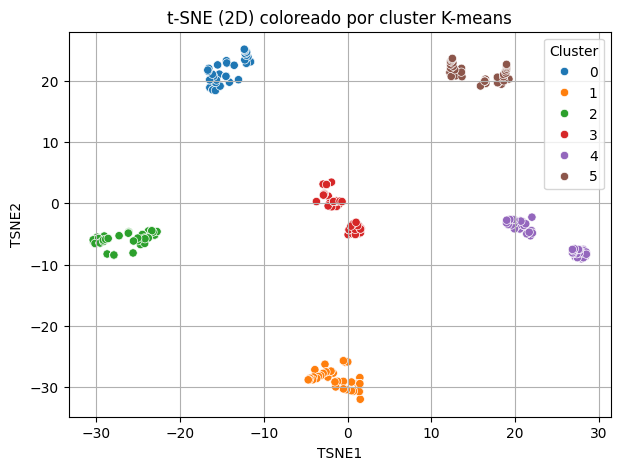

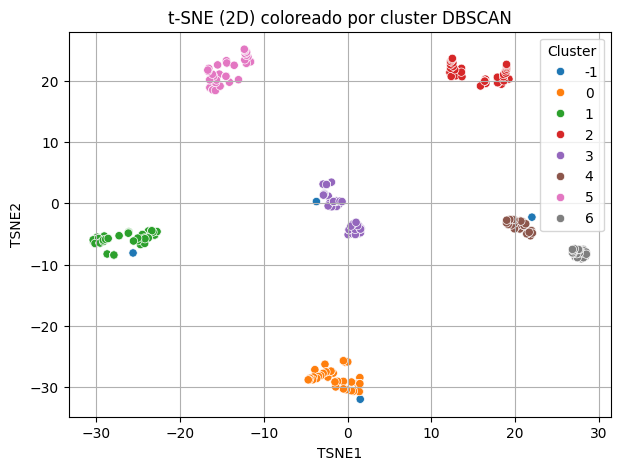

In [66]:
# ===========================
# 6.2. t-SNE para visualización
# ===========================

from sklearn.manifold import TSNE

# t-SNE suele tardar un poco; usamos una configuración estándar
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="random",
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
df_tsne["KMeans_Cluster"] = cluster_labels
df_tsne["DBSCAN_Cluster"] = dbscan_labels

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_tsne,
    x="TSNE1",
    y="TSNE2",
    hue="KMeans_Cluster",
    palette="tab10"
)
plt.title("t-SNE (2D) coloreado por cluster K-means")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_tsne,
    x="TSNE1",
    y="TSNE2",
    hue="DBSCAN_Cluster",
    palette="tab10"
)
plt.title("t-SNE (2D) coloreado por cluster DBSCAN")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


In [67]:
df_km_vars.groupby("KMeans_Cluster").mean().round(2)


,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase,Gender_Male,City_Houston,City_Los Angeles,City_Miami,City_New York,City_San Francisco,Membership Type_Gold,Membership Type_Silver,Discount Applied_True
KMeans_Cluster,,,,,,,,,,,,,,
0,36.71,446.89,7.57,3.19,22.76,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30.71,1165.04,15.27,4.54,24.59,0.02,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,34.12,805.49,11.68,4.17,15.27,1.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,29.12,1459.77,20.00,4.81,11.17,1.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,28.95,690.39,11.64,3.93,45.50,0.98,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
5,42.02,499.88,9.41,3.46,40.47,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [68]:
# ============================================
# 7. Resumen de características por cluster
# ============================================

# Partimos de df_encoded (features numéricas) y añadimos el cluster de K-means
df_summary = df_encoded.copy()
df_summary["Cluster"] = cluster_labels

# Calculamos la media de cada variable por cluster
cluster_means = df_summary.groupby("Cluster").mean().round(2)
cluster_means


,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase,Gender_Male,City_Houston,City_Los Angeles,City_Miami,City_New York,City_San Francisco,Membership Type_Gold,Membership Type_Silver,Discount Applied_True
Cluster,,,,,,,,,,,,,,
0,36.71,446.89,7.57,3.19,22.76,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30.71,1165.04,15.27,4.54,24.59,0.02,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,34.12,805.49,11.68,4.17,15.27,1.00,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,29.12,1459.77,20.00,4.81,11.17,1.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,28.95,690.39,11.64,3.93,45.50,0.98,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
5,42.02,499.88,9.41,3.46,40.47,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0



### 1. ¿Qué tipo de perfiles se pueden identificar?

A partir de las medias por cluster (sobre esas columnas) se pueden describir segmentos como:

* **Clientes de bajo valor y baja actividad**
  Edad y *Total Spend* bajos, pocos *Items Purchased* y *Days Since Last Purchase* alto. Aparecen con mayor peso en algunas ciudades y en membresías Bronze/básicas; usan poco los descuentos (`Discount Applied_True` bajo).

* **Clientes de valor medio, comportamiento estable**
  Valores intermedios en *Total Spend* e *Items Purchased*, recencia moderada y *Average Rating* aceptable (alrededor del valor medio global). Mezcla de tipos de membresía y uso ocasional de descuentos.

* **Clientes de alto valor y alta lealtad**
  *Total Spend* elevado, muchos *Items Purchased* y *Days Since Last Purchase* bajo (compras recientes y frecuentes). Alta proporción de `Membership Type_Gold` o `Membership Type_Silver`, uso intensivo de descuentos y *Average Rating* alto.

* **Perfiles específicos por ciudad o demografía**
  Algunos clusters se diferencian más por las variables dummy (`City_*`, `Gender_Male`) que por el nivel de gasto: por ejemplo, un grupo con concentración en una ciudad concreta y mayor presencia de un género, aún manteniendo niveles similares de *Total Spend*.

Con esas ideas puedes redactar 4–6 perfiles concretos, usando tu tabla de medias.

---

### 2. ¿Qué diferencias clave surgieron entre los modelos?

* **K-means**

  * Utiliza todas las columnas de `df_encoded` (ya escaladas) y genera clusters de tamaño y forma aproximadamente esférica.
  * Obligó a fijar un número de clusters; tras analizar el método del codo y el índice de silueta se seleccionó un k que produce grupos bien separados en las dimensiones de *Total Spend*, *Items Purchased* y *Days Since Last Purchase*.
  * Asigna todos los clientes a algún cluster, por lo que es muy útil para una segmentación operativa (etiquetar a cada cliente con un “segmento”).

* **DBSCAN**

  * No requiere especificar k; descubre agrupamientos a partir de la **densidad** en el espacio de las variables (el mismo espacio que se construye a partir de esa tabla).
  * Permite marcar algunos puntos como ruido (`label = -1`), identificando clientes atípicos que K-means fuerza a incluir en algún cluster.
  * Con los parámetros elegidos (eps y min_samples) encontró un número de clusters similar al de K-means, pero con fronteras distintas: algunos grupos son más compactos y otros clientes quedan etiquetados como ruido, lo que resalta patrones “núcleo” frente a casos aislados.

En síntesis: K-means da una partición más regular y fácil de implementar; DBSCAN es mejor para detectar densidades fuertes y outliers en esa misma tabla de características.

---

### 3. ¿Qué limitaciones encontraron y cómo las abordarían?

**Limitaciones:**

* El conjunto de variables está limitado a lo que aparece en la tabla (`Age`, `Total Spend`, `Items Purchased`, `Average Rating`, `Days Since Last Purchase` y dummies de género/ciudad/membresía/descuento); no incluye información de canal de adquisición, tipo de producto o comportamiento de navegación, por lo que los perfiles capturan solo una parte del comportamiento real del cliente.
* K-means supone clusters más o menos esféricos y de tamaño similar; si la estructura verdadera en ese espacio es más compleja, algunos grupos pueden quedar forzados.
* DBSCAN es muy sensible a la elección de `eps` y `min_samples`; pequeños cambios en esos parámetros, dados esos mismos atributos, pueden cambiar mucho el número de clusters y el ruido.
* No se validó la estabilidad temporal de los clusters ni su impacto directo en métricas de negocio (ingreso, margen, respuesta a campañas).

**Cómo abordarlas:**

* **Enriquecer el dataset** incorporando nuevas variables (historial de navegación, tipo de producto, canal, dispositivo, etc.) y más observaciones para robustecer los patrones.
* **Probar modelos adicionales** (clustering jerárquico, Gaussian Mixture Models) sobre la misma tabla para comparar si capturan mejor la estructura de los datos.
* **Validar con negocio**: analizar diferencias de KPIs reales entre clusters (por ejemplo, ingreso medio por cluster, tasa de respuesta a campañas) y revisar con el equipo de marketing si los segmentos resultantes son accionables.
* **Evaluar estabilidad**: repetir el clustering en distintas muestras o periodos y comparar si los clusters que se forman a partir de `df_encoded` son consistentes en el tiempo.

